# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation. 通过skip-gram连续跳跃元语法结构实现词嵌入

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 
one_hot编码造成大量稀疏矩阵，对计算资源较大浪费
![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit. 类似于自编码器，通过权重来编码输入向量，通过训练让他们自动理解上下文语境，得到了词干

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.
因为输入向量是大量的稀疏矩阵，所以采用词查找表的方法来简化乘法操作  
<img src='assets/tokenize_lookup.png' width=500>  
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.
采用word2vec可以得到相似语境的词汇


## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.
两种类型的word2vec，CBOW和SKIP_GRAM两种，将高维稀疏的输入向量转换成低维向量空间
<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.  获得相似语境，理解相似词汇

First up, importing packages.

###  这里是utils库,预置的utils库
#### 实现了几个功能，1是对标点符号的处理，2是采用counter计数器对单词表进行清洗，对超低频(<5次)数据进行过滤  3创造按照频率排序的单词表

In [4]:
import re
from collections import Counter

def preprocess(text): # 两个功能：一个是对标点符号的处理，另一个是采用counter计数器对单词表进行清洗，对超低频(<5次)数据进行过滤

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: A list where each item is a tuple of (batch of input, batch of target).
    """
    n_batches = int(len(int_text) / (batch_size * seq_length))

    # Drop the last few characters to make only full batches
    xdata = np.array(int_text[: n_batches * batch_size * seq_length])
    ydata = np.array(int_text[1: n_batches * batch_size * seq_length + 1])

    x_batches = np.split(xdata.reshape(batch_size, -1), n_batches, 1)
    y_batches = np.split(ydata.reshape(batch_size, -1), n_batches, 1)

    return list(zip(x_batches, y_batches))


def create_lookup_tables(words):#创造单词查找表，按照单词的出现频率排序后创造单词索引表
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}#dict类似的查找表，key是数字索引，value是单词
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}#跟以上相反

    return vocab_to_int, int_to_vocab

In [5]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.
载入text8的文本数据

In [7]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)




Text8 Dataset:   1%|▎                      | 393k/31.3M [00:46<58:29, 8.82kB/s]


KeyboardInterrupt: 

In [6]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile      

dataset_folder_path=r'F:\uav+ai\神经网络test\第三课循环神经网络\5嵌入和word2vec\text8'

with open(dataset_folder_path) as f:
    text = f.read()
text[:300]    

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organiz'

## Preprocessing  采用前面预置的utils库对数据清理

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.
数据预处理两个方面1、对标点符号等进行处理 2、对低频的词汇删除，即噪声过滤了
#### 采用set（）集合的数据类型可以快速得到单词表,采用counter计数器和dict数据类型可以快速实现该单词索引表功能

In [7]:
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [8]:
print("Total words: {}".format(len(words)))#总的词汇数 
print("Unique words: {}".format(len(set(words))))#不重复词汇表数，即单词表数

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`. 
#### 采用counter计数器实现单词索引表的功能，并实现对输入单词进行向量化编码

In [9]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]#通过单词查找表对以上的字符串编码成数字
int_words #

[5239,
 3080,
 11,
 5,
 194,
 1,
 3135,
 45,
 58,
 155,
 127,
 741,
 476,
 10620,
 133,
 0,
 27473,
 1,
 0,
 102,
 854,
 2,
 0,
 15198,
 60636,
 1,
 0,
 150,
 854,
 3583,
 0,
 194,
 10,
 190,
 58,
 4,
 5,
 10767,
 214,
 6,
 1325,
 104,
 454,
 19,
 58,
 2731,
 362,
 6,
 3673,
 0,
 708,
 1,
 371,
 26,
 40,
 36,
 53,
 540,
 97,
 11,
 5,
 1423,
 2757,
 18,
 567,
 686,
 7099,
 0,
 247,
 5239,
 10,
 1052,
 27,
 0,
 320,
 248,
 45991,
 2880,
 792,
 186,
 5239,
 11,
 5,
 200,
 602,
 10,
 0,
 1135,
 19,
 2622,
 25,
 9012,
 2,
 279,
 31,
 4147,
 141,
 59,
 25,
 6448,
 4197,
 1,
 153,
 32,
 362,
 5239,
 36,
 1137,
 6,
 447,
 344,
 1818,
 19,
 4862,
 0,
 6765,
 1,
 7573,
 1775,
 566,
 0,
 93,
 0,
 247,
 11131,
 11,
 51,
 7099,
 89,
 26,
 270,
 37,
 5958,
 4868,
 20477,
 28,
 55234,
 41,
 317,
 5,
 26001,
 527,
 7573,
 371,
 4,
 258,
 1,
 153,
 25,
 1206,
 11,
 7573,
 200,
 1577,
 2,
 15223,
 332,
 1775,
 7099,
 4862,
 344,
 764,
 160,
 406,
 5704,
 756,
 1,
 4116,
 1132,
 4341,
 1536,
 2,
 567,
 8

In [10]:
len(int_words)

16680599

## Subsampling  对单词进行处理 构建训练数据
### 1删除超高频词汇

### 2训练样本的形式是(input word, output word)，其中output word是input word的上下文

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 我们采用以下公式来计算每个单词被删除的概率大小：

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$
其中 f(wi) 代表单词 wi 的出现频次。t为一个阈值，一般介于1e-3到1e-5之间。

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`. 计算每个单词被抛弃的概率

#### 首先计算词频，然后对应计算每个单词的频率，最后计算概率，再选择概率小于阈值的保留

In [11]:
int_word_counts=Counter(int_words)#采用counter计数器对词频进行计数
print(int_word_counts)   #可以看到最低频率的是6次，因为上面已经滤去了5次以下
total_word_num=len(int_words)#总单词数   注意 总单词数和总单词表数是不一样的
print(int_words)

Counter({0: 1061396, 1: 593677, 2: 416629, 3: 411764, 4: 372201, 5: 325873, 6: 316376, 7: 264975, 8: 250430, 9: 192644, 10: 183153, 11: 131815, 12: 125285, 13: 118445, 14: 116710, 15: 115789, 16: 114775, 17: 112807, 18: 111831, 19: 109510, 20: 108182, 21: 102145, 22: 99683, 23: 95603, 24: 91250, 25: 76527, 26: 73334, 27: 72871, 28: 68945, 29: 62603, 30: 61925, 31: 61281, 32: 58832, 33: 54788, 34: 54576, 35: 53573, 36: 44358, 37: 44033, 38: 39712, 39: 39086, 40: 37866, 41: 35358, 42: 32433, 43: 31523, 44: 29567, 45: 28810, 46: 28553, 47: 28161, 48: 28100, 49: 26229, 50: 26223, 51: 25563, 52: 25519, 53: 25383, 54: 24413, 55: 24096, 56: 23997, 57: 23770, 58: 22737, 59: 22707, 60: 21125, 61: 20623, 62: 20484, 63: 20477, 64: 20412, 65: 19864, 66: 19463, 67: 19206, 68: 19115, 69: 18807, 70: 17949, 71: 17581, 72: 17516, 73: 17377, 74: 17236, 75: 16155, 76: 15861, 77: 15737, 78: 15574, 79: 15122, 80: 14935, 81: 14916, 82: 14696, 83: 14629, 84: 14578, 85: 14494, 86: 14437, 87: 14420, 88: 14151,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
int_word_counts.items()

dict_items([(0, 1061396), (1, 593677), (2, 416629), (3, 411764), (4, 372201), (5, 325873), (6, 316376), (7, 264975), (8, 250430), (9, 192644), (10, 183153), (11, 131815), (12, 125285), (13, 118445), (14, 116710), (15, 115789), (16, 114775), (17, 112807), (18, 111831), (19, 109510), (20, 108182), (21, 102145), (22, 99683), (23, 95603), (24, 91250), (25, 76527), (26, 73334), (27, 72871), (28, 68945), (29, 62603), (30, 61925), (31, 61281), (32, 58832), (33, 54788), (34, 54576), (35, 53573), (36, 44358), (37, 44033), (38, 39712), (39, 39086), (40, 37866), (41, 35358), (42, 32433), (43, 31523), (44, 29567), (45, 28810), (46, 28553), (47, 28161), (48, 28100), (49, 26229), (50, 26223), (51, 25563), (52, 25519), (53, 25383), (54, 24413), (55, 24096), (56, 23997), (57, 23770), (58, 22737), (59, 22707), (60, 21125), (61, 20623), (62, 20484), (63, 20477), (64, 20412), (65, 19864), (66, 19463), (67, 19206), (68, 19115), (69, 18807), (70, 17949), (71, 17581), (72, 17516), (73, 17377), (74, 17236), 

In [21]:
t=1e-5 
threshold=0.8 #门槛概率，频率太高就删除
word_freqs={word:count/total_word_num for  word ,count in int_word_counts.items()}#计算每个单词对应的词频 ，并且已经按照降频排序了
word_delete_probability={word:1-np.sqrt(t/freq) for word,freq in word_freqs.items()} #计算每个单词被抛弃的概率
train_words=[word for word  in int_words if word_delete_probability[word] <0.8]

#### 另一种方式：

In [23]:
from collections import Counter
import random
import numpy as np
threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [24]:
len(train_words)

4626870

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."我们先来分析一下skip-gram的样本格式。skip-gram不同于CBOW，CBOW是基于上下文预测当前input word。而skip-gram则是基于一个input word来预测上下文，因此一个input word会对应多个上下文。我们来举个栗子“The quick brown fox jumps over lazy dog”，如果我们固定skip_window=2的话，那么fox的上下文就是[quick, brown, jumps, over]，如果我们的batch_size=1的话，那么实际上一个batch中有四个训练样本。

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window. 这里R和C代表：C代表设定的窗口宽度大小，即skip_windows,而R是随机取1-C中间的随机数作为实际窗口数

In [25]:
C=5
R = np.random.randint(1, C+1) #代表1-C之间的随机数
R

1

#### 上面的分析转换为代码就是两个步骤，第一个是找到每个input word的上下文，第二个就是基于上下文构建batch。

In [26]:
def get_target(words, idx, window_size):#获取input_word的上下文，即获取窗口单词 idx代表的input词在窗口words列表中的索引
    R = np.random.randint(1, window_size+1)
    start=idx-R if(idx-R)>0 else 0
    end =idx+R
    #输出即窗口中的上下文单词
    targets=set(words[start:idx]+words[idx:end+1])
    return list(targets)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [27]:
def get_batches(words, batch_size, window_size):#创造一个迭代器来获取batch
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size] #取整数个batch
    
    for idx in range(0, len(words), batch_size):#每间隔batch_size取数
        x, y = [], []
        batch = words[idx:idx+batch_size]  #将batch的窗口词取出
        for ii in range(len(batch)):
            batch_x = batch[ii] #然后逐个来组成input和output词汇
            batch_y = get_target(batch, ii, window_size)#这里返回的是的以input为中心的窗口词汇list
            y.extend(batch_y)# extend() 函数用于在列表末尾一次性追加另一个序列中的多个值用新列表扩展原来的列表
            x.extend([batch_x]*len(batch_y))#重复写了多次,为了和batch_y对齐
        yield x, y


#### list.append(object) 向列表中添加一个对象object
#### list.extend(sequence) 把一个序列seq的内容添加到列表中

In [28]:
batches = get_batches(train_words, 1000, 10)#batch返回两个一维list，x和y
x,y=next(batches)   #每个batch为1000个单词，每个单词对应的窗口是0-20之间的随机数即平均值为10，则大概xy的长度都是10000
print(np.shape(x))
print(np.shape(y))
print(np.shape(np.array(x)))
print(np.shape(np.array(y)[:, None]))

(11487,)
(11487,)
(11487,)
(11487, 1)


#### #这里的xy均是一维列表
###### 即x=[ batch1，batch1，batch1，batch1，batch1  ,  batch2，batch2，batch2，batch2，batch2  ,  batch3，batch3，batch3，batch3，batch3]  ]
###### y=[ bathch1周边词汇5个单词  ,  bathch2周边词汇   ,   bathch3周边词汇    ]

#### 注意上面代码中batch的获取方法，首先将整个words分割成每个batch，每个batch的长度是batch_size，然后逐个对batch里的词汇进行处理，每个词被当做input，然后去获取在batch里他的上下文词汇

#### 注意上面的代码对batch的处理。我们知道对于每个input word来说，有多个output word（上下文）。例如我们的输入是“fox”，上下文是[quick, brown, jumps, over]，那么fox这一个batch中就有四个训练样本[fox, quick], [fox, brown], [fox, jumps], [fox, over]。

## Building the graph 模型的构建

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.三层网络，隐层是线性单元，输出层是softmax层

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.训练神经网络，然后保留隐层的向量即可，真正需要的就是隐层的低维向量表示形式，这即是嵌入词

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [29]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')#因为神经网络的输出是1*64631，应该写成矩阵的形式而不是向量

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform). tensorflow提供了embedding_lookup查找表的功能，即实现了乘法功能，即1*63641的稀疏矩阵与63641*200的权重矩阵相乘，等同于查找权重矩阵的的某一个行，最后返回一个行向量即1*200

In [30]:
n_vocab = len(int_to_vocab)
n_vocab

63641

In [31]:

n_embedding = 200 # Number of embedding features #隐层单元数，即需要用于表达词汇的维度
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))#63641*200，随机数分布在-1到1之间
    embed = tf.nn.embedding_lookup(embedding, inputs)#embedding_lookup实现了查找表的功能，即矩阵乘法，e

In [32]:
embedding

<tf.Variable 'Variable:0' shape=(63641, 200) dtype=float32_ref>

In [33]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(?, 200) dtype=float32>

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).为了提高训练效果，采用负采样的方式来实现更新权重

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

####  负采样（negative sampling)训练一个神经网络意味着要输入训练样本并且不断调整神经元的权重，从而不断提高对目标的准确预测。每当神经网络经过一个训练样本的训练，它的权重就会进行一次调整。正如我们上面所讨论的，vocabulary的大小决定了我们的Skip-Gram神经网络将会拥有大规模的权重矩阵，所有的这些权重需要通过我们数以亿计的训练样本来进行调整，这是非常消耗计算资源的，并且实际中训练起来会非常慢。

#### 负采样（negative sampling）解决了这个问题，它是用来提高训练速度并且改善所得到词向量的质量的一种方法。不同于原本每个训练样本更新所有的权重，负采样每次让一个训练样本仅仅更新一小部分的权重，这样就会降低梯度下降过程中的计算量

#### 当我们用训练样本 ( input word: "fox"，output word: "quick") 来训练我们的神经网络时，“fox”和“quick”都是经过one-hot编码的。如果我们的vocabulary大小为10000时，在输出层，我们期望对应“quick”单词的那个神经元结点输出1，其余9999个都应该输出0.在这里，这9999个我们期望输出为0的神经元结点所对应的单词我们称为“negative” word。

#### 在论文中，作者指出指出对于小规模数据集，选择5-20个negative words会比较好，对于大规模数据集可以仅选择2-5个negative words

In [34]:
# Number of negative labels to sample
n_sampled = 100 
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))#64634*200 的隐层至输出层权重矩阵??
    softmax_b = tf.Variable(tf.zeros(n_vocab)) 
    
    # Calculate the loss using negative sampling  #sampled_softmax_loss用于实现负采样
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b,  #embed为隐层输出为1*200
                                      labels, embed,
                                      n_sampled, n_vocab)#n_sampled和n_vocab是为了设置负采样的参数，这里的y输入不用热独编码，只需要用一个list输入
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



#### 请注意代码中的softmax_w的维度是vocab_size x embedding_size，这是因为TensorFlow中的sampled_softmax_loss中参数weights的size是[num_classes, dim]。

In [35]:
softmax_b

<tf.Variable 'Variable_2:0' shape=(63641,) dtype=float32_ref>

## Validation 随机挑选16个词，用于训练过程中观察和其他最近的词汇

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [36]:
import random
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 从不同部位0-100和1000-1100挑选8个单词
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance: 将权重矩阵单位化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))#求范数
    normalized_embedding = embedding / norm#依然是65631*200
    #查找16个验证单词的词向量 并经过了上述的单位化处理
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)#valid_dataset是验证单词16*1，得到是隐层的向量16*200
    #计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))#shape=(16, 63641) 代表是每行代表的当前词和其他词的相似度

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [37]:
similarity

<tf.Tensor 'MatMul:0' shape=(16, 63641) dtype=float32>

In [38]:
valid_examples

array([  22,   18,    8,   15,   99,   87,   68,   36, 1042, 1010, 1064,
       1005, 1099, 1057, 1006, 1060])

In [39]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

子目录或文件 checkpoints 已经存在。


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

#### 注意：在程序中并没有对输入和输出数据进行热独编码，是embedding_lookup查找表实现了热度编码的功能，即输入是一个list为11000的向量，但实际上输入应该是一个11000*65631的一个经过热独编码的矩阵，而embedding_lookup本质上实现了这个功能,节省了输入的存储空间和矩阵乘法计算时间。
#### 实际上算输出的时候也是用y矩阵为11000*1来计算，因为loss = tf.nn.sampled_softmax_loss这个函数同样节省了热独编码的逆过程，只需要将y为11000 * 1的标签输入即可以计算loss
####  实际上的计算的过程是输入11000 * 1,经过热独编码为11000* 65631, 经过输入到隐层的权重矩阵65631 * 200得到隐层向量单元11000 * 200，再经过隐层200 * 65631的权重矩阵的变化得到输出层矩阵11000 * 65631，通过反热独编码则为11000 * 1

In [ ]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)#batch返回两个一维list，x和y
        start = time.time()
        for x, y in batches:           
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}  #label应当写成矩阵的形式
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)

            loss += train_loss

            if iteration % 200 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()

            if iteration % 2000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)

            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 200 Avg. Training loss: 11.1785 0.0542 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 10.7550 0.0506 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 10.5677 0.0508 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 10.4743 0.0514 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 10.2985 0.0513 sec/batch
Epoch 1/10 Iteration: 1200 Avg. Training loss: 10.2135 0.0515 sec/batch
Epoch 1/10 Iteration: 1400 Avg. Training loss: 9.9421 0.0510 sec/batch
Epoch 1/10 Iteration: 1600 Avg. Training loss: 9.7346 0.0508 sec/batch
Epoch 1/10 Iteration: 1800 Avg. Training loss: 9.6023 0.0510 sec/batch
Epoch 1/10 Iteration: 2000 Avg. Training loss: 9.4380 0.0510 sec/batch
Nearest to seven: bixby, vogue, succeed, tien, cannot, boating, biro, responsibilities,
Nearest to by: ever, hostname, prematurely, monastery, fanbase, bernstein, higson, dragon,
Nearest to nine: marvelous, seaside, commentary, doo, quick, cap, gbu, commonly,
Nearest to five: were, suffi

Restore the trained network if you need to:

In [81]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [67]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [68]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

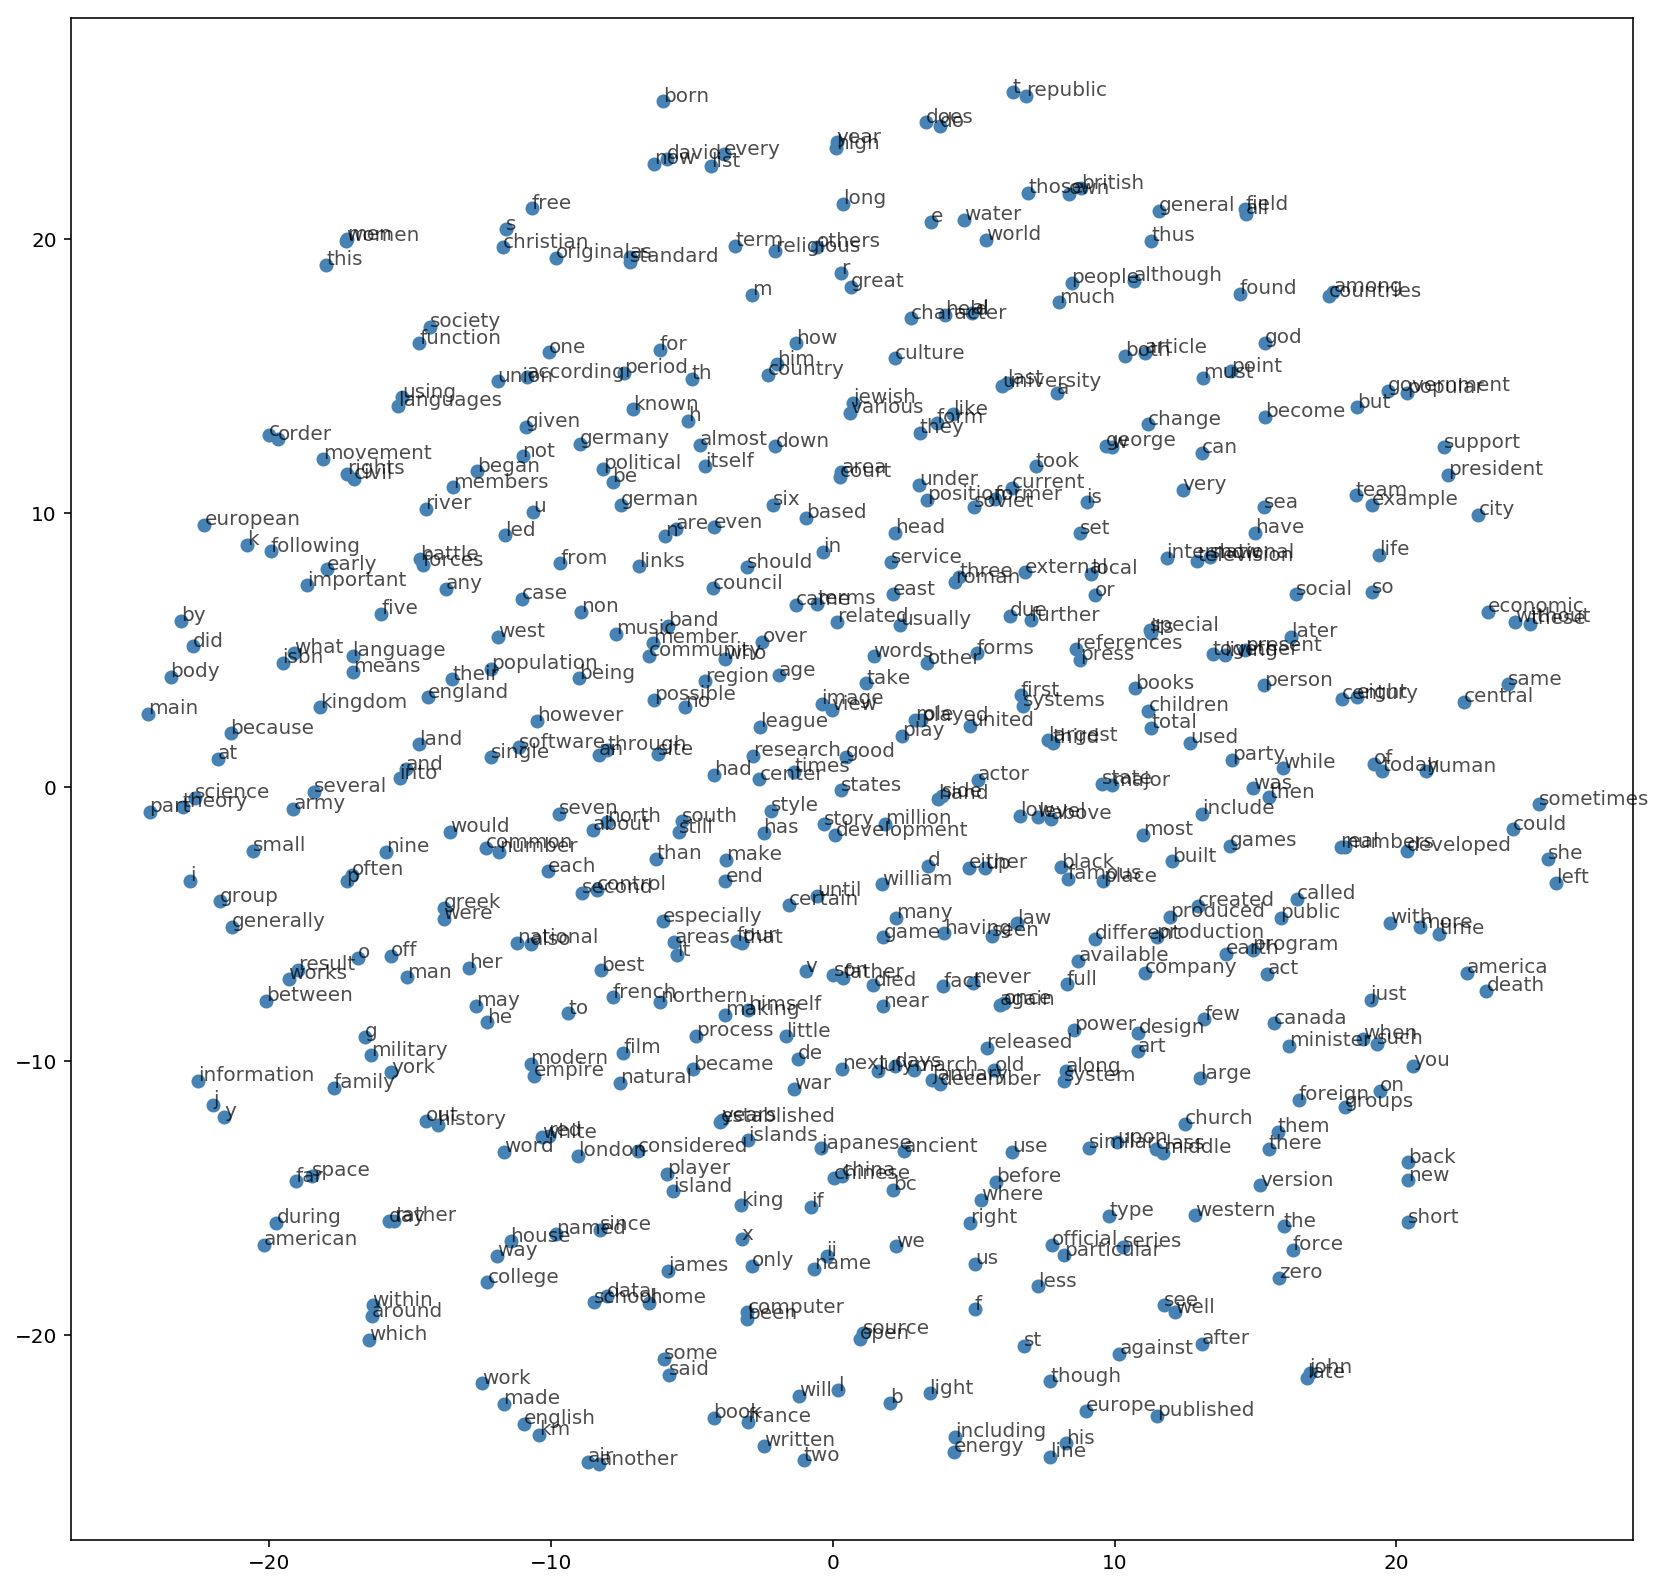

In [69]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)